In [1]:
import calendar 
import datetime
import dask.dataframe as dd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import SVG, display

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')
#plt.style.available

In [3]:
%%time
# set data file path
data_file_name = '../data/crimes-2017.snappy.parq'
print('Loading data file: {}'.format(data_file_name))

# load crimes parquet data into dask df
crimes = dd.read_parquet(data_file_name, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading data file: ../data/crimes-2017.snappy.parq
Crime data loaded into memory.
Wall time: 2.79 s


In [4]:
%%time
# log records count and load data partitions
print('Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Crime data stats:
---------------------------------------
157,543 total records in 1 partitions
DataFrame size: 1,417,887
Wall time: 3.91 ms


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude
npartitions=1,,,,,,,,,
2017-01-01 00:00:00,object,object,object,object,float64,bool,bool,float64,float64
2017-08-07 23:58:00,...,...,...,...,...,...,...,...,...


In [6]:
# preview crimes data with Date index
crimes.head()

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,,
2017-08-07 12:00:00,091XX S ESSEX AVE,ASSAULT,SIMPLE,APARTMENT,48.0,False,True,41.729299,-87.563364
2017-08-07 21:30:00,078XX S KINGSTON AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,43.0,False,True,41.752843,-87.562617
2017-08-07 21:15:00,012XX W 79TH ST,ROBBERY,STRONGARM - NO WEAPON,PARK PROPERTY,71.0,True,False,41.750471,-87.655560
2017-08-07 23:00:00,018XX E 95TH ST,MOTOR VEHICLE THEFT,AUTOMOBILE,GAS STATION,51.0,False,False,41.722428,-87.578680
2017-08-07 11:25:00,069XX S STATE ST,OTHER OFFENSE,HARASSMENT BY TELEPHONE,STREET,69.0,False,True,41.768728,-87.624946


In [7]:
# get crime types
crime_types = crimes[['PrimaryType']]
crime_types.head()

,PrimaryType
Date,
2017-08-07 12:00:00,ASSAULT
2017-08-07 21:30:00,BATTERY
2017-08-07 21:15:00,ROBBERY
2017-08-07 23:00:00,MOTOR VEHICLE THEFT
2017-08-07 11:25:00,OTHER OFFENSE


In [8]:
# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# print crime stats
print(crime_type_total.sort_values(ascending=False))
print("...\nTotal Primary Crime Types: {:,}".format(crime_type_total.size))

PrimaryType
THEFT                                36954
BATTERY                              29783
CRIMINAL DAMAGE                      17552
ASSAULT                              11678
OTHER OFFENSE                        10765
DECEPTIVE PRACTICE                   10136
BURGLARY                              7685
MOTOR VEHICLE THEFT                   6759
ROBBERY                               6657
NARCOTICS                             6400
CRIMINAL TRESPASS                     4192
WEAPONS VIOLATION                     2802
OFFENSE INVOLVING CHILDREN            1250
PUBLIC PEACE VIOLATION                 934
CRIM SEXUAL ASSAULT                    888
INTERFERENCE WITH PUBLIC OFFICER       671
SEX OFFENSE                            548
PROSTITUTION                           521
HOMICIDE                               408
ARSON                                  277
LIQUOR LAW VIOLATION                   131
STALKING                               123
GAMBLING                               112

In [9]:
# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']].groupby('PrimaryType').sum().compute()

# print arrests stats
print(crime_type_counts.sort_values(by='Arrest', ascending=False))

                                   Arrest  Domestic
PrimaryType                                        
NARCOTICS                          6397.0       5.0
BATTERY                            5912.0   14512.0
THEFT                              3674.0    1404.0
CRIMINAL TRESPASS                  2517.0     203.0
OTHER OFFENSE                      2407.0    3324.0
WEAPONS VIOLATION                  2239.0      11.0
ASSAULT                            2074.0    3005.0
CRIMINAL DAMAGE                    1040.0    2039.0
INTERFERENCE WITH PUBLIC OFFICER    631.0       3.0
PUBLIC PEACE VIOLATION              626.0      31.0
MOTOR VEHICLE THEFT                 540.0      66.0
PROSTITUTION                        521.0       0.0
ROBBERY                             407.0     124.0
DECEPTIVE PRACTICE                  378.0      92.0
BURGLARY                            270.0     105.0
OFFENSE INVOLVING CHILDREN          151.0     629.0
LIQUOR LAW VIOLATION                131.0       1.0
GAMBLING    

In [10]:
# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic + total)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic  Total
PrimaryType                                               
THEFT                              3674.0    1404.0  36954
BATTERY                            5912.0   14512.0  29783
CRIMINAL DAMAGE                    1040.0    2039.0  17552
ASSAULT                            2074.0    3005.0  11678
OTHER OFFENSE                      2407.0    3324.0  10765
DECEPTIVE PRACTICE                  378.0      92.0  10136
BURGLARY                            270.0     105.0   7685
MOTOR VEHICLE THEFT                 540.0      66.0   6759
ROBBERY                             407.0     124.0   6657
NARCOTICS                          6397.0       5.0   6400
CRIMINAL TRESPASS                  2517.0     203.0   4192
WEAPONS VIOLATION                  2239.0      11.0   2802
OFFENSE INVOLVING CHILDREN          151.0     629.0   1250
PUBLIC PEACE VIOLATION              626.0      31.0    934
CRIM SEXUAL ASSAULT                  31.0     120.0    8

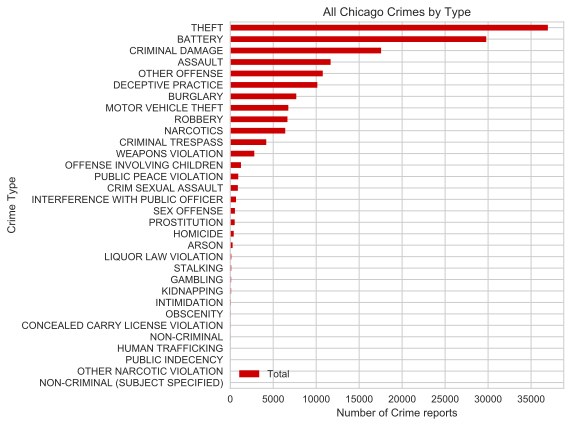

In [11]:
# plot crimes by primary type counts
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True)\
.drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(8,6), color='#cc0000')
plt.title('All Chicago Crimes by Type')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

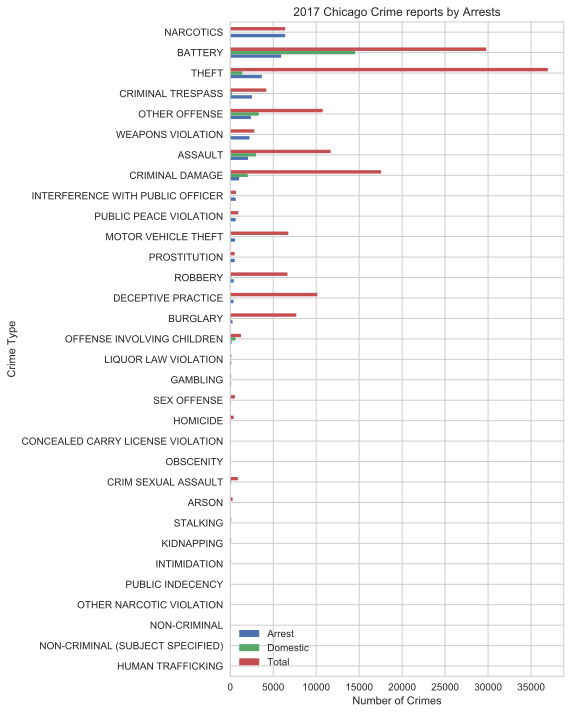

In [12]:
# plot crimes by arrests
crime_type_counts.sort_values(by='Arrest', ascending=True)\
.plot(kind='barh', figsize=(8,10))
plt.title('2017 Chicago Crime reports by Arrests')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

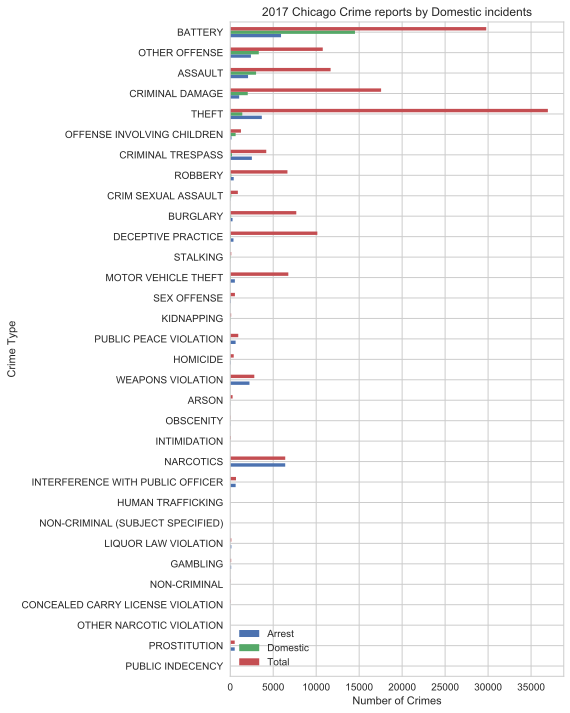

In [13]:
# plot crimes by domestic incident reports
crime_type_counts.sort_values(by='Domestic', ascending=True)\
.plot(kind='barh', figsize=(8,10))
plt.title('2017 Chicago Crime reports by Domestic incidents')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

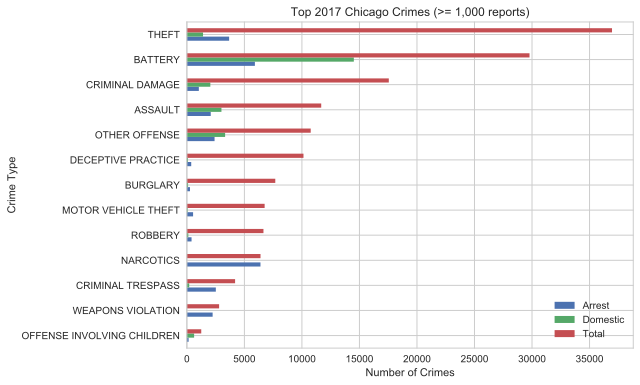

In [14]:
# plot top crimes (>-= 1,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 1000]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(8,6))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Top 2017 Chicago Crimes (>= 1,000 reports)')

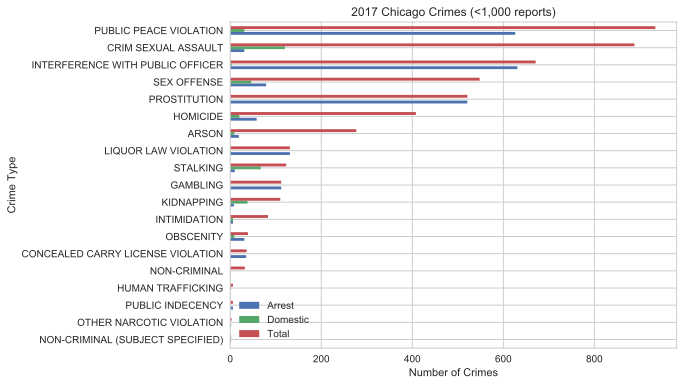

In [15]:
# plot less than 1000 crime reports types
crime_type_counts[crime_type_counts['Total'] < 1000]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(8,6))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crimes (<1,000 reports)')

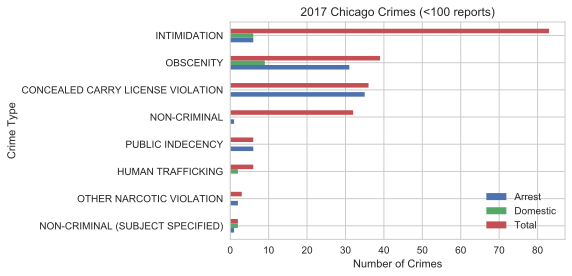

In [16]:
# plot less than 100 crime reports types
crime_type_counts[crime_type_counts['Total'] < 100]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crimes (<100 reports)')

In [17]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       35608
RESIDENCE    26900
APARTMENT    19889
SIDEWALK     12425
OTHER         6511
Name: Total, dtype: int64
...
Total Locations: 121


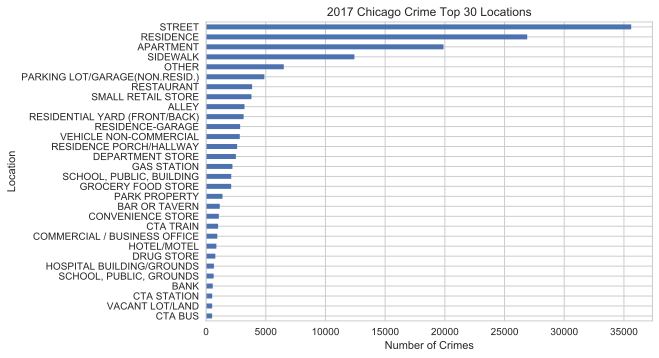

In [18]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top 30 Locations')

In [19]:
# get arrests and domestic counts for each location description
crime_location_counts = crimes[['LocationDescription', 'Arrest', 'Domestic']]\
.groupby('LocationDescription').sum().compute()

# add crime location totals column
crime_location_counts['Total'] = crime_locations
crime_location_counts.head()

,Arrest,Domestic,Total
LocationDescription,,,
ABANDONED BUILDING,91.0,7.0,207
AIRCRAFT,4.0,0.0,37
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,7.0,1.0,55
AIRPORT BUILDING NON-TERMINAL - SECURE AREA,5.0,2.0,46
AIRPORT EXTERIOR - NON-SECURE AREA,6.0,1.0,50


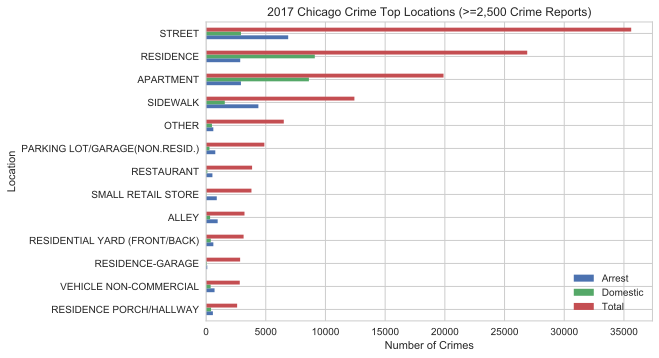

In [20]:
# plot top crime locations with arrests and domestic crime counts
crime_location_counts[crime_location_counts['Total'] >= 2500]\
.sort_values(by='Total', ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top Locations (>=2,500 Crime Reports)')

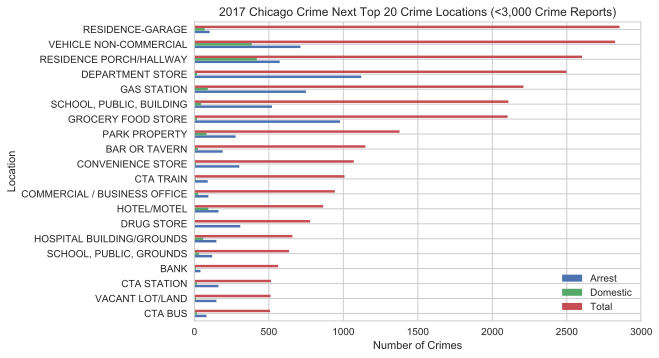

In [21]:
# plot next 20 top crime locations
crime_location_counts = crime_location_counts[crime_location_counts['Total'] <= 3000]\
.sort_values(by='Total', ascending=False)
crime_location_counts[:20].sort_values(by='Total', ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Next Top 20 Crime Locations (<3,000 Crime Reports)')

In [22]:
# check for datetime64 index to plot crime over time
crimes.index

Dask Index Structure:
npartitions=1
2017-01-01 00:00:00    datetime64[ns]
2017-08-07 23:58:00               ...
Name: Date, dtype: datetime64[ns]
Dask Name: read-parquet, 2 tasks

In [23]:
# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

Date
2017-08-07 21:15:00    True
2017-08-07 23:09:00    True
2017-08-07 22:53:00    True
2017-08-07 22:42:00    True
2017-08-07 23:29:00    True
Name: Arrest, dtype: bool
...
Total Arrests: 30,314


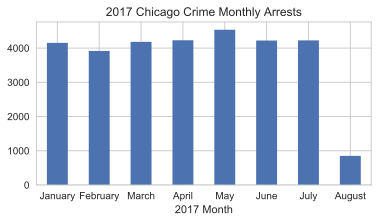

In [24]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(kind='bar', figsize=(6,3))

plt.xticks([0,1,2,3,4,5,6,7], calendar.month_name[1:13], rotation=0)
plt.xlabel('2017 Month')
plt.title('2017 Chicago Crime Monthly Arrests')
plt.show()

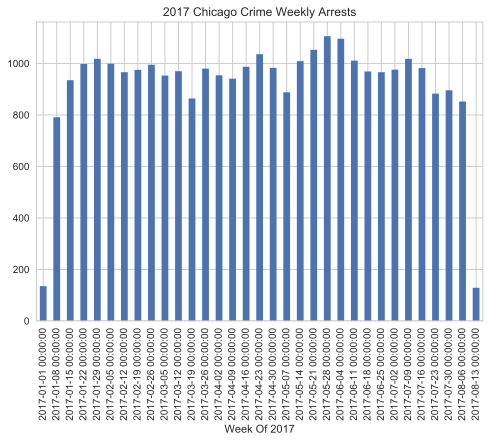

In [25]:
# plot weekly arrests
weekly_arrests = arrests.resample('W').sum().compute()
weekly_arrests.plot(kind='bar')

# TODO: format weekly xticks to only list week start date
plt.xlabel('Week Of 2017')
plt.title('2017 Chicago Crime Weekly Arrests')
plt.show()

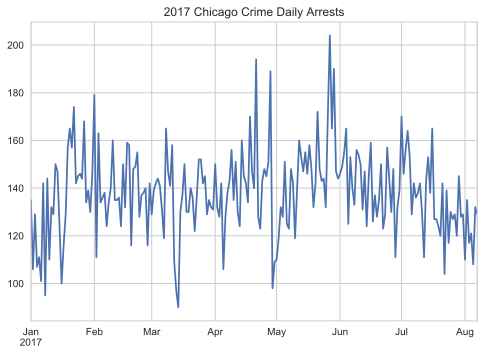

In [26]:
# plot daily arrests
daily_arrests = arrests.resample('D').sum().compute()
daily_arrests.plot()
plt.title('2017 Chicago Crime Daily Arrests')
plt.show()

In [27]:
# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))

Date
2017-08-07 12:00:00    True
2017-08-07 21:30:00    True
2017-08-07 11:25:00    True
2017-08-07 12:00:00    True
2017-08-07 09:00:00    True
Name: Domestic, dtype: bool
...
Total Domestic: 25,873


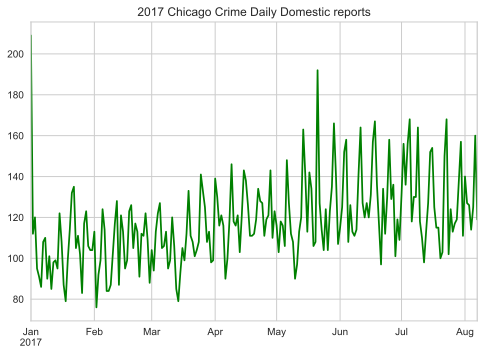

In [28]:
# plot daily domestic crimes
daily_domestic = domestic.resample('D').sum().compute()
daily_domestic.plot(color='g')
plt.title('2017 Chicago Crime Daily Domestic reports')
plt.show()

In [29]:
# get daily total crime counts
daily_crime = crime_types.resample('D').count().compute()

#print daily total crime stats
print(daily_crime.head())
print("...\nTotal Days: {:,}".format(daily_crime.size))

            PrimaryType
2017-01-01          928
2017-01-02          601
2017-01-03          704
2017-01-04          610
2017-01-05          601
...
Total Days: 219


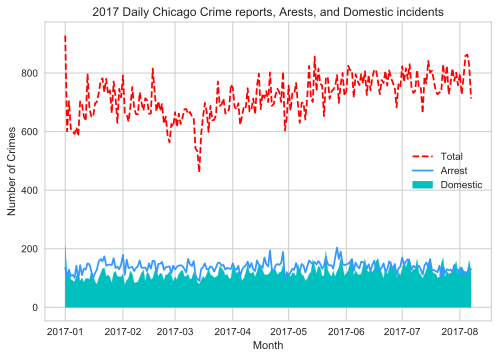

In [30]:
# plot daily crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots()
ax.plot(daily_crime.index, daily_crime, '--', label='Total', color='r', zorder=10)
ax.plot(daily_arrests.index, daily_arrests, color='#3399ff', zorder=10)
ax.fill_between(daily_domestic.index, daily_domestic, label='Domestic', color='c')
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Month')
ax.legend(loc='right')
plt.title('2017 Daily Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

In [31]:
# get select human endangerment crimes
violent_crimes = crime_types[(crime_types['PrimaryType']=='CRIM SEXUAL ASSAULT') | \
                             (crime_types['PrimaryType']=='HOMICIDE') | \
                             (crime_types['PrimaryType']=='HUMAN TRAFFICKING') | \
                             (crime_types['PrimaryType']=='KIDNAPPING') | \
                             (crime_types['PrimaryType']=='OFFENSE INVOLVING CHILDREN')]

# print violent crimes stats
print(violent_crimes.head(10))
print('...............................................')
print(violent_crimes.PrimaryType.value_counts().head(5))

                                    PrimaryType
Date                                           
2017-08-07 09:00:00  OFFENSE INVOLVING CHILDREN
2017-08-07 02:00:00         CRIM SEXUAL ASSAULT
2017-08-07 03:30:00         CRIM SEXUAL ASSAULT
2017-08-07 23:30:00         CRIM SEXUAL ASSAULT
2017-08-07 22:45:00         CRIM SEXUAL ASSAULT
2017-08-07 12:00:00         CRIM SEXUAL ASSAULT
2017-08-06 09:00:00  OFFENSE INVOLVING CHILDREN
2017-07-22 12:00:00  OFFENSE INVOLVING CHILDREN
2017-08-07 13:58:00                    HOMICIDE
2017-08-05 11:30:00  OFFENSE INVOLVING CHILDREN
...............................................
OFFENSE INVOLVING CHILDREN    1250
CRIM SEXUAL ASSAULT            888
HOMICIDE                       408
KIDNAPPING                     110
HUMAN TRAFFICKING                6
Name: PrimaryType, dtype: int64


In [32]:
# categorize by primary type
violent_crimes = violent_crimes.categorize(columns='PrimaryType')
print(violent_crimes)

# print selected violent crimes primary type categories
print('\nSelected Primary Type categories:')
print('----------------------------------------------------------------------')
print(violent_crimes.PrimaryType.cat.categories)

Dask DataFrame Structure:
                         PrimaryType
npartitions=1                       
2017-01-01 00:00:00  category[known]
2017-08-07 23:58:00              ...
Dask Name: _categorize_block, 14 tasks

Selected Primary Type categories:
----------------------------------------------------------------------
Index(['OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'HOMICIDE',
       'HUMAN TRAFFICKING', 'KIDNAPPING'],
      dtype='object', name='PrimaryType')


In [33]:
# group violent crimes by month and crime type
violent_crimes_groupby = violent_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
violent_crime_data = violent_crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(violent_crime_data.head(10))
print('...')

# unstack violent crime type group for series plotting
violent_crime_data = violent_crime_data.unstack()
print(violent_crime_data.head(12))

print("...\nTotal Monthly/Type records: {:,}".format(violent_crime_data.size))

Date        PrimaryType               
2017-01-31  OFFENSE INVOLVING CHILDREN    215
            CRIM SEXUAL ASSAULT           135
            HOMICIDE                       53
            KIDNAPPING                      8
2017-02-28  OFFENSE INVOLVING CHILDREN    119
            CRIM SEXUAL ASSAULT           118
            HOMICIDE                       48
            KIDNAPPING                     13
2017-03-31  OFFENSE INVOLVING CHILDREN    175
            CRIM SEXUAL ASSAULT            95
Name: Count, dtype: int64
...
PrimaryType  OFFENSE INVOLVING CHILDREN  CRIM SEXUAL ASSAULT  HOMICIDE  \
Date                                                                     
2017-01-31                        215.0                135.0      53.0   
2017-02-28                        119.0                118.0      48.0   
2017-03-31                        175.0                 95.0      37.0   
2017-04-30                        171.0                131.0      46.0   
2017-05-31                 

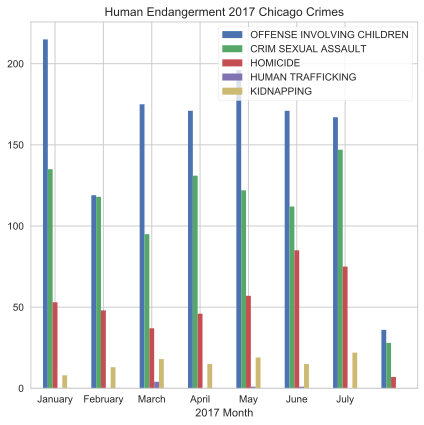

In [34]:
# plot violent crime data
violent_crime_data.plot(figsize=(6,6), kind='bar')
plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Human Endangerment 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [35]:
# get top 5 crimes
top_5_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                             (crime_types['PrimaryType']=='BATTERY') | \
                             (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                             (crime_types['PrimaryType']=='ASSAULT') | \
                             (crime_types['PrimaryType']=='OTHER OFFENSE')]
top_5_crimes.head(10)

,PrimaryType
Date,
2017-08-07 12:00:00,ASSAULT
2017-08-07 21:30:00,BATTERY
2017-08-07 11:25:00,OTHER OFFENSE
2017-08-07 12:00:00,BATTERY
2017-08-07 09:00:00,OTHER OFFENSE
2017-08-07 22:53:00,BATTERY
2017-08-07 18:00:00,BATTERY
2017-08-07 23:05:00,BATTERY
2017-08-07 23:51:00,THEFT


In [36]:
# print top 5 crime counts
top_5_crimes.PrimaryType.value_counts().head()

THEFT              36954
BATTERY            29783
CRIMINAL DAMAGE    17552
ASSAULT            11678
OTHER OFFENSE      10765
Name: PrimaryType, dtype: int64

In [37]:
print('Monthly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by month and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))

Monthly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-31  ASSAULT            1373
            BATTERY            3557
            CRIMINAL DAMAGE    2407
            OTHER OFFENSE      1550
            THEFT              4926
2017-02-28  ASSAULT            1294
            BATTERY            3407
            CRIMINAL DAMAGE    2044
            OTHER OFFENSE      1372
            THEFT              4372
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  CRIMINAL DAMAGE  OTHER OFFENSE  THEFT
Date                                                                
2017-01-31      1373     3557             2407           1550   4926
2017-02-28      1294     3407             2044           1372   4372
2017-03-31      1481     3851             2231           1507   4466
2017-04-30      1635     4094             2439           1549   4751
2017-05-31      1843     4552             2507           1606   5291
201

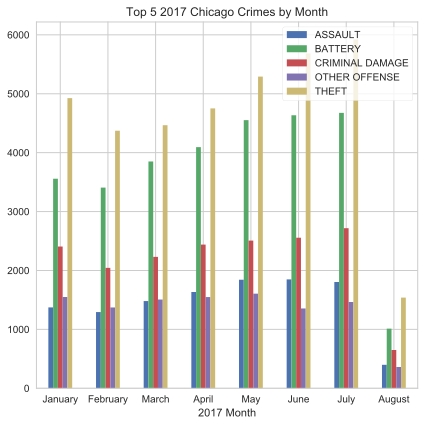

In [38]:
# plot top 5 crimes data
top_5_crime_data.plot(figsize=(6,6), kind='bar')

plt.xticks([0,1,2,3,4,5,6,7], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Top 5 2017 Chicago Crimes by Month')
plt.tight_layout()
plt.show()

In [39]:
print('Weekly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by week and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('W'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Weekly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  ASSAULT             45
            BATTERY            202
            CRIMINAL DAMAGE    113
            OTHER OFFENSE       70
            THEFT              177
2017-01-08  ASSAULT            300
            BATTERY            714
            CRIMINAL DAMAGE    477
            OTHER OFFENSE      336
            THEFT              909
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  CRIMINAL DAMAGE  OTHER OFFENSE  THEFT
Date                                                                
2017-01-01        45      202              113             70    177
2017-01-08       300      714              477            336    909
2017-01-15       292      766              524            383   1076
2017-01-22       338      815              568            349   1234
2017-01-29       312      824              569            319   1198
2017-02-05    

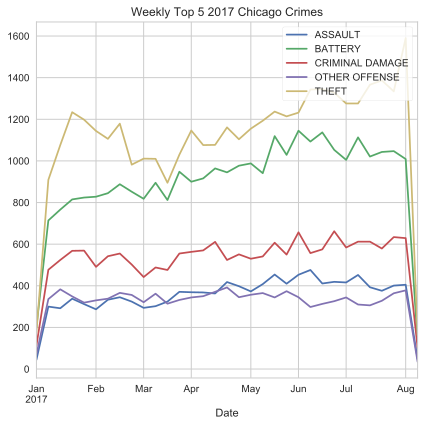

In [40]:
# add weekly arrests data for comparison of crime fighting efforts
#top_5_crime_data['Arrests'] = weekly_arrests

# plot Weekly top 5 crimes data
top_5_crime_data.plot(figsize=(6,6))
plt.legend(loc='upper right', frameon=True)
plt.title('Weekly Top 5 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [41]:
print('Daily Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by day and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('D'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Daily Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  ASSAULT             45
            BATTERY            202
            CRIMINAL DAMAGE    113
            OTHER OFFENSE       70
            THEFT              177
2017-01-02  ASSAULT             38
            BATTERY            105
            CRIMINAL DAMAGE     73
            OTHER OFFENSE       44
            THEFT              120
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  CRIMINAL DAMAGE  OTHER OFFENSE  THEFT
Date                                                                
2017-01-01        45      202              113             70    177
2017-01-02        38      105               73             44    120
2017-01-03        55      114               79             43    149
2017-01-04        34       95               57             54    161
2017-01-05        42       84               68             56    132
2017-01-06     

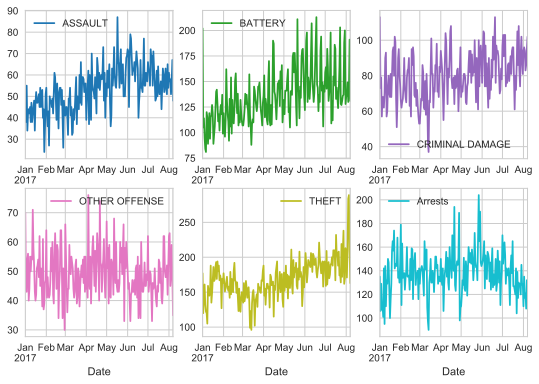

In [42]:
# add daily arrests data for comparison of crime fighting efforts
top_5_crime_data['Arrests'] = daily_arrests

# plot top 5 daily crimes grid
top_5_crime_data.plot(figsize=(9, 6), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [43]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

,CommunityArea,CommunityName,Side
0,0,NaN,NaN
1,1,Rogers Park,Far North Side
2,2,West Ridge,Far North Side
3,3,Uptown,Far North Side
4,4,Lincoln Square,Far North Side


In [44]:
# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName       Side  Total
25             25           Austin  West Side   9219
8               8  Near North Side    Central   6752
32             32             Loop    Central   6075
28             28   Near West Side  West Side   5311
29             29   North Lawndale  West Side   5197
...
Total Communities: 77


In [45]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,9219
Near North Side,6752
Loop,6075
Near West Side,5311
North Lawndale,5197


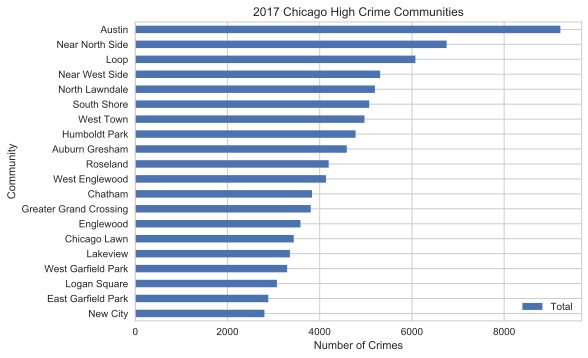

In [46]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago High Crime Communities')

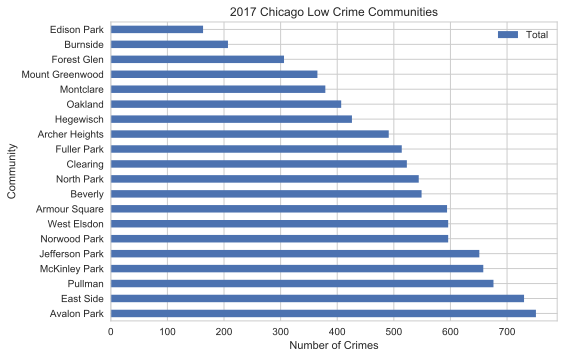

In [47]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False).plot(kind='barh')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Low Crime Communities')

In [48]:
community_areas.head()

,CommunityArea,CommunityName,Side,Total
0,0,NaN,NaN,1
1,1,Rogers Park,Far North Side,2399
2,2,West Ridge,Far North Side,2058
3,3,Uptown,Far North Side,2016
4,4,Lincoln Square,Far North Side,1081


In [49]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum().drop('CommunityArea', axis=1) # denotes column
crime_by_side

,Total
Side,
Central,13954
Far North Side,13679
Far Southeast Side,18475
Far Southwest Side,10093
North Side,11123
Northwest Side,8590
South Side,20578
Southwest Side,21120
West Side,39930


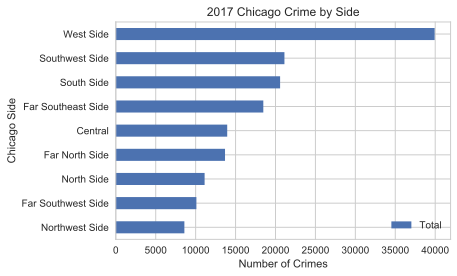

In [50]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4))
plt.ylabel('Chicago Side')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime by Side')

In [51]:
# show Chicago sides svg for reference
display(SVG(url='../data/chicago-community-areas.svg'))

<IPython.core.display.SVG object>